In [175]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from unidecode import unidecode
pd.set_option('display.max_columns',30)

In [176]:
giay_nam = pd.read_csv('D:\TIKI\giay-nam.csv')
giay_nu = pd.read_csv('D:\TIKI\giay-nu.csv')
giay_nam = giay_nam.drop(columns=['Unnamed: 0'])
giay_nu = giay_nu.drop(columns=['Unnamed: 0'])

In [177]:
giay_nam_id = pd.read_csv('giay-nam-id.csv',usecols=['product_id','category_name'])
giay_nu_id = pd.read_csv('giay-nu-id.csv',usecols=['product_id','category_name'])
giay_nam_id = giay_nam_id.drop_duplicates()
giay_nu_id = giay_nu_id.drop_duplicates()

In [178]:
giay_nam = giay_nam.merge(giay_nam_id,left_on='id',right_on='product_id',how='left')
giay_nu = giay_nu.merge(giay_nu_id,left_on='id',right_on='product_id',how='left')
giay_nam = giay_nam.drop(columns=['product_id'])
giay_nu = giay_nu.drop(columns=['product_id'])

In [179]:
#I add tag 'man' / 'woman' into category_name to ensure that there are no identical category name in both table when concatenated later
giay_nam['category_name'] = 'MAN-'+giay_nam['category_name']
giay_nam['root_category'] = 'giay-nam'

giay_nu['category_name'] = 'WOMAN-'+giay_nu['category_name']
giay_nu['root_category'] = 'giay-nu'

In [180]:
last_update = '2023-06-18 18:00:00'
concat_df = pd.concat([giay_nam,giay_nu])
concat_df['last_update'] = pd.to_datetime(last_update)
concat_df = concat_df.reset_index()
concat_df = concat_df.drop(columns='index')
concat_df = concat_df.drop_duplicates(subset=['id'])

In [181]:
concat_df.sample(3)

,id,sku,name,discription,original_price,list_price,price,alltime_quantity_sold,quantity_sold,inventory_status,fulfillment_type,brand,category_id,category,review_count,rating_average,favourite_count,ASA_cashback,pay_later,current_seller,date_created,video_url,category_name,root_category,last_update
34781,193666825,8685432332266,Dép sandal nữ Bitas SYN.187_RÊU,Sandal nữ với kiểu dáng thời trang trẻ ...,260000,260000,260000,{},NaN,available,dropship,Bita's,2,Root,0,0.0,0,"Thưởng 1,30 ASA (≈ 278đ)","{'title': 'Trả góp 0%', 'summary': 'Mua trước ...",Mạnhanhshoes,214,NaN,WOMAN-giay-sandals-de-bang,giay-nu,2023-06-18 18:00:00
21061,111821471,1620066144889,Dép Gấu Đúc Nguyên Khối Nhiều Màu Cho Nam Nữ,"️Dép làm hoàn toàn từ nhựa EVA cao cấp,...",108800,108800,108800,22,22.0,available,dropship,OEM,2,Root,6,2.8,0,"Thưởng 0,54 ASA (≈ 116đ)","{'title': 'Trả góp 0%', 'summary': 'Mua trước ...",BlueStoreVina,708,NaN,WOMAN-dep-di-trong-nha,giay-nu,2023-06-18 18:00:00
33108,204417955,8716073741796,giày silipon vải dạ kim tuyến,GIÀY SILIPON VẢI DẠ KIM TUYẾN thiết kế trẻ tru...,139000,139000,139000,2,2.0,available,dropship,OEM,49566,Giày búp bê mũi tròn,0,0.0,0,"Thưởng 20,01 ASA (≈ 4.302đ)","{'title': 'Trả góp 0%', 'summary': 'Mua trước ...",Rumyh Fashion Style,225,NaN,WOMAN-giay-bup-be-mui-tron,giay-nu,2023-06-18 18:00:00


## PREPROCESSING DATA

In [182]:
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42648 entries, 0 to 42980
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     42648 non-null  int64         
 1   sku                    42648 non-null  int64         
 2   name                   42648 non-null  object        
 3   discription            42648 non-null  object        
 4   original_price         42648 non-null  int64         
 5   list_price             42648 non-null  int64         
 6   price                  42648 non-null  int64         
 7   alltime_quantity_sold  42648 non-null  object        
 8   quantity_sold          13295 non-null  float64       
 9   inventory_status       42648 non-null  object        
 10  fulfillment_type       42647 non-null  object        
 11  brand                  42648 non-null  object        
 12  category_id            42648 non-null  int64         
 13  c

In [183]:
concat_df['has_video'] = concat_df['video_url'].notna()
concat_df['alltime_quantity_sold'] = concat_df['alltime_quantity_sold'].replace('{}',0).astype(int)
concat_df['quantity_sold'] = concat_df['quantity_sold'].fillna(0)
concat_df['rating_average'] = concat_df['rating_average']
concat_df['ASA_cashback_transformed'] = concat_df['ASA_cashback'].apply(lambda x: float(x.split()[1].replace(',','.')))
concat_df['pay_later'] = concat_df['pay_later'].notna()

In [184]:
#In my random investigation of item name, i found out that there are a number of products which are actually not shoes but classified
# in shoes category(both men's and women's)
keyword = ['giay', 'dep', 'boot', 'guoc', 'boots', 'xuc', 'suc', 'sandal', 'got', 'xang dan',
           'sandan', 'chai', 've sinh', 'dung', 'bot', 'sneaker', 'sneakers', 'ung','tong','crocs',
           'marten']
ascii_keywords = [unidecode(word) for word in keyword]

concat_df['name_normal'] = concat_df['name'].str.lower().apply(unidecode)
concat_df['discription_normal'] = concat_df['discription'].str.lower().apply(unidecode)

concat_df = concat_df.loc[((concat_df['name_normal'].str.contains('|'.join(ascii_keywords))) | (concat_df['discription_normal'].str.contains('|'.join(ascii_keywords))))]

the results has filtered out >200 id not relevant. Mostly socks, shirts, etc.

# check duplicate columns

In [186]:
#check 'alltime_quantity_sold' vs 'quantity_sold'
print(concat_df.loc[concat_df['alltime_quantity_sold'].astype(float) != concat_df['quantity_sold']])

#check 'original_price' vs 'list_price'
print(concat_df.loc[concat_df['list_price'] != concat_df['original_price']])

Empty DataFrame
Columns: [id, sku, name, discription, original_price, list_price, price, alltime_quantity_sold, quantity_sold, inventory_status, fulfillment_type, brand, category_id, category, review_count, rating_average, favourite_count, ASA_cashback, pay_later, current_seller, date_created, video_url, category_name, root_category, last_update, has_video, ASA_cashback_transformed, name_normal, discription_normal]
Index: []
Empty DataFrame
Columns: [id, sku, name, discription, original_price, list_price, price, alltime_quantity_sold, quantity_sold, inventory_status, fulfillment_type, brand, category_id, category, review_count, rating_average, favourite_count, ASA_cashback, pay_later, current_seller, date_created, video_url, category_name, root_category, last_update, has_video, ASA_cashback_transformed, name_normal, discription_normal]
Index: []


In [187]:
concat_df = concat_df.drop(columns=['quantity_sold','original_price'])

## DATA SUMMARY 

In [188]:
concat_df.sample(3)

,id,sku,name,discription,list_price,price,alltime_quantity_sold,inventory_status,fulfillment_type,brand,category_id,category,review_count,rating_average,favourite_count,ASA_cashback,pay_later,current_seller,date_created,video_url,category_name,root_category,last_update,has_video,ASA_cashback_transformed,name_normal,discription_normal
9128,181362718,3812943087489,Giày Tây Nam Derby Da Bò Cao Cấp Thuộc Nguyên ...,"Thời trang luôn luôn thay đổi theo thời gian, ...",1845000,1845000,1,available,dropship,B21 B21 SHOEMAKER,49630,Giày tây nam có dây,0,0.0,0,"Thưởng 160,87 ASA (≈ 34.747đ)",True,B21 Shoemaker Official,396,NaN,MAN-giay-tay-nam-co-day,giay-nam,2023-06-18 18:00:00,False,160.87,giay tay nam derby da bo cao cap thuoc nguyen ...,"thoi trang luon luon thay doi theo thoi gian, ..."
28224,205177946,9584563716519,Sandal bánh mì DÂY TRÒN QUAI XÍCH NGANG mẫu mớ...,️Chất liệu : Chất liệu tổng hợp ️ ☇☇B...,129000,129000,0,available,dropship,OEM,2,Root,0,0.0,0,"Thưởng 0,65 ASA (≈ 138đ)",True,JerryShop0801,220,NaN,WOMAN-giay-cao-got-ho-mui,giay-nu,2023-06-18 18:00:00,False,0.65,sandal banh mi day tron quai xich ngang mau mo...,chat lieu : chat lieu tong hop bang ...
40559,169274528,4636265643786,Miếng lót giày hương quế khử mùi hôi chân hiệu...,LÓT GIÀY HƯƠNG QUẾ VỀ NHIỀU !!! Sử Dụ...,39000,39000,0,available,dropship,OEM,2,Root,0,0.0,0,"Thưởng 0,20 ASA (≈ 41đ)",False,Kho Tổng Hợp 86,463,NaN,WOMAN-mieng-lot-giay,giay-nu,2023-06-18 18:00:00,False,0.20,mieng lot giay huong que khu mui hoi chan hieu...,lot giay huong que ve nhieu !!! su du...


In [189]:
concat_df['fulfillment_type'].value_counts()

dropship           42060
seller_delivery      216
tiki_delivery        166
cross_border           1
Name: fulfillment_type, dtype: int64

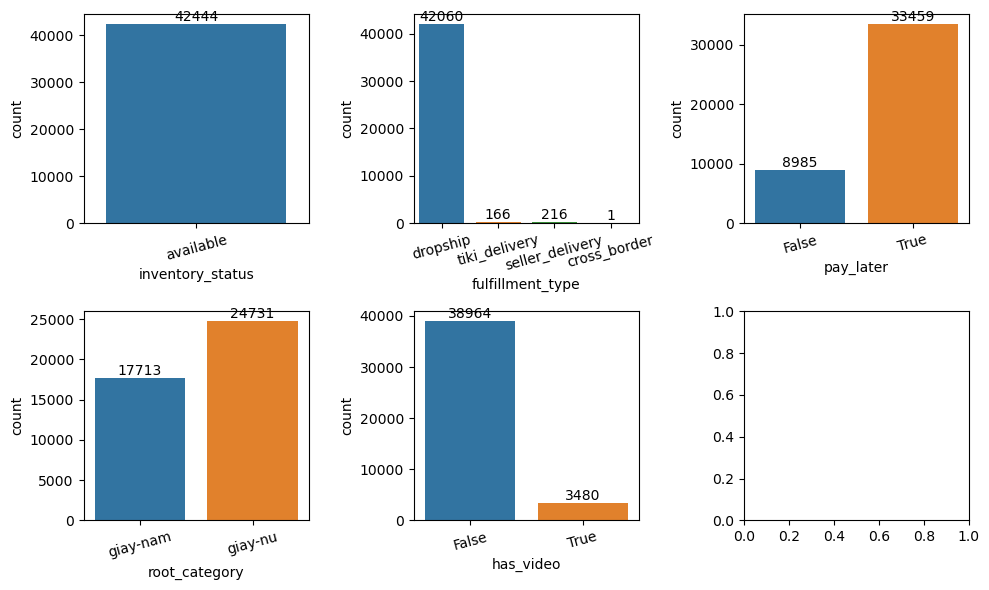

In [190]:
cat_cols = ['inventory_status', 'fulfillment_type', 'pay_later', 'root_category', 'has_video']
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=3)

for col, ax in zip(cat_cols, axes.ravel()):
    sns.countplot(data=concat_df, x=col, ax=ax)
    for container in ax.containers:
        ax.bar_label(container)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15)

plt.tight_layout()

- 'inventory_status': there is only 1 value 'available' -> we can drop this column
- 'fulfillment_type': dropship is the dominant fulfillment type in these category. Dropship means the sellers send products to TIKI then TIKI takes care of delivery. TIKI_delivery means the sellers give products priorly to TIKI warehouse (consignment selling) then TIKI takes care of all afterward delivery. seller_delivery means the sellers send goods directly to customers themselves. Cross_border means selling overseas
- 'Pay_later': It is surpring that low-price, common products like shoes having pay_later policy available. I think that this is an 'add-on service' only and it does not have any usability here as a role of customers.
- 'Root-category': Women's shoes have more products listed on TIKI in comparison with men's. ALso, sub-categories inside womens'shoes are also more than men's footwears.
- 'has_video': This feature indicates whether or not the sellers have short_clips on product's postings

# COMPARISON BETWEEN TWO ROOT CATEGORY

In [191]:
concat_df.sample()

,id,sku,name,discription,list_price,price,alltime_quantity_sold,inventory_status,fulfillment_type,brand,category_id,category,review_count,rating_average,favourite_count,ASA_cashback,pay_later,current_seller,date_created,video_url,category_name,root_category,last_update,has_video,ASA_cashback_transformed,name_normal,discription_normal
25979,176907368,3173669633625,Nút gắn hkdesign/ phụ kiện trang trí loại đá c...,***[Kẹo m&m] Nút gắn hkdesign/ phụ kiện...,8000,8000,10,available,dropship,OEM,2,Root,1,5.0,0,"Thưởng 0,04 ASA (≈ 8đ)",False,NDK Phukienxinh,418,NaN,WOMAN-phu-kien-cho-giay,giay-nu,2023-06-18 18:00:00,False,0.04,nut gan hkdesign/ phu kien trang tri loai da c...,***[keo m&m] nut gan hkdesign/ phu kien...


In [192]:
grouped_df = concat_df.groupby('root_category').mean()
grouped_df

,id,sku,list_price,price,alltime_quantity_sold,category_id,review_count,rating_average,favourite_count,pay_later,date_created,has_video,ASA_cashback_transformed
root_category,,,,,,,,,,,,,
giay-nam,1.600049e+08,5.481450e+12,417995.579687,363424.077119,7.801219,20174.050020,2.004573,1.020115,0.0,0.828939,498.566025,0.093604,12.367400
giay-nu,1.699752e+08,5.493413e+12,358273.167725,316818.513364,6.968097,20776.330921,1.380777,0.758869,0.0,0.759209,453.555578,0.073673,20.473504
